# This is my notebook from a Kaggle competition I placed 1st in as part of a capstone for an NLP Practicum. I took the below steps:
1. Reading in files (pandas)
2. Punctuation and html cleaning (regex, string)
3. Data Augmentation (nltk)
4. Vecorization (sklearn)
5. Modeling & Evaluation (keras, tensorflow, gpu)
6. Obtain Final Predictions (keras, tensorflow, gpu)
7. Ensembling
8. Results

All this analysis was performed in a Kaggle notebook

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk # stopwords, wordnet for synonyms
import string # punctuation
import re # data cleaning
import tensorflow as tf # gpu, 

# GPU handling in kaggle notebook
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 1. Reading in Files:


In [4]:
# read in train and test files; structure is: ID, Text, Sentiment ("positive", "negative")
train = pd.read_csv('/kaggle/input/us-nlp-practicum-2020-a/imdb_train.csv')
test = pd.read_csv('/kaggle/input/us-nlp-practicum-2020-a/imdb_test.csv')

In [5]:
# add numeric encoding of sentiment
train['label'] = train['sentiment'].apply(lambda x: 1 if x=="positive" else 0)

### 2. Data Cleaning:
- **Idea**: we will remove punctuation and html tags from the reviews
- **Takeaway**: now we will be able to process the data more accurately


In [4]:
# first, going to clean the punctuation and tags from the documents:
removed_punc = [re.sub('['+string.punctuation+']','',i.replace('<br /><br />',' ')) for i in train['review'].values]
removed_punc_test = [re.sub('['+string.punctuation+']','',i.replace('<br /><br />',' ')) for i in test['review'].values]

#### Here is an example of the cleaning:

'We had STARZ free weekend and I switched on the station to see what was on . It was this movie Howling II: The acting was terrible but the eye candy was great. Sybil Danning and Marsha Brown as the afore mentioned eye candy. I was laughing a lot from the few scenes I saw. My friends wonder why I never want to go to Horror movies , If they saw this film they would know why. I would get thrown out for laughing so hard. Just a couple of trivia notes : Reb Brown who played Ben White had played Captain American in a made for TV movie Marsha Brown was Mick Jaggers inspiration for the song "Brown Sugar" Mick has great taste in women for sure.'

'We had STARZ free weekend and I switched on the station to see what was on  It was this movie Howling II The acting was terrible but the eye candy was great Sybil Danning and Marsha Brown as the afore mentioned eye candy I was laughing a lot from the few scenes I saw My friends wonder why I never want to go to Horror movies  If they saw this film they would know why I would get thrown out for laughing so hard Just a couple of trivia notes  Reb Brown who played Ben White had played Captain American in a made for TV movie Marsha Brown was Mick Jaggers inspiration for the song Brown Sugar Mick has great taste in women for sure'

### 3. Data Augmentation:
- **Idea**: we will replace certain words with their synonyms and assume that this does not change the label that is associated with the review, thus allowing the model to learn from a broader array of words and see words in supplementary contexts
- **Takeaway**: we were given 40,000 training records; with synonym-based data augmentation we have 80,000


In [5]:
# data augmentation:
from nltk.corpus import wordnet

# leverage nltk english stopwords list
sw = nltk.corpus.stopwords.words('english')

# get_synonyms taken from https://maelfabien.github.io/machinelearning/NLP_8/#synonym-replacement-sr 
# and adapted to also remove stopwords from potential synonyms
def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
        
    
    return [s for s in synonyms if s not in sw]

# creating the new reviews
new_reviews = []
for review in removed_punc:
    new_review = []
    for word in review.split(" "):
        syns = get_synonyms(word)
        p = np.random.uniform(0,1) # random number drawn from uniform distribution
        if p < .5 and len(word)>3: # if word > 3: replace with synonym with 50% probability; 
            if len(syns)==0: # if no synonyms returned
                new_review.append(word)
            else:     
                new_word = syns[np.random.randint(0,max([1,len(syns)-1]))] # replace with random synonym from those returned
                new_review.append(new_word)
        else:
            new_review.append(word)
    new_reviews.append(new_review)
    
augmentation = [" ".join(i) for i in new_reviews] # new reviews
aug_labels = train['label'].values.tolist() # labels for the new_reviews

**Original review:** 
'The BBC surpassed themselves with the boundaries they crossed with Tipping the Velvet In the past theyve been daring with Dennis Potters works but this miniseries as it was screened in the UK is superb Andrew Davies work is top notch  Ive not read the Sarah Waters novel but I can imagine hes done it real justice I comment on the bawdiness  most men have watched it for that  proved to be a main talking and selling point when originally advertised The fact is it portays the lesbian side of society in the 1800s  a time when most thought it was old men and rent boys  well it was  lesbianism took place mainly behind closed and often respectable doors You can also look at Tipping The Velvet as a love story  it actually is  as well as self discovery that many gaybi and straight people go through and comments on this occur and repeat all the time If youve not seen it yet  either repeated on TV or on DVD  get it  youll be in for a treat  and even the production and filming of it is perfect Just try to hide your blushes in parts  like I said  bawdy is the order of the day  and beware a phallus or two Enjoy'

**Same review with synonym replacement:** 
'The BBC surpassed themselves with the bound they hybridize with Tipping the velvet textured In the yesteryear theyve follow daring with Dennis ceramist work on but this miniseries as it was screened in the UK is superb Andrew Davies work is top notch  Ive not read the sarah Waters novel but I can imagine hes done it real jurist I comment on the bawdiness  most men have watched it for that  proved to be a main talking and betray point when originally advertised The fact is it portays the sapphic english of society in the 1800s  a clock time when virtually think it was old men and economic rent boys  well it was  sapphism lead office mainly tush closed and often respectable door You can besides look at tippytoe The Velvet as a love story  it actually is  as intimately as self breakthrough that many gaybi and uncoiled people go through and gossip on this occur and repeat all the clock time If youve not seen it yet  either ingeminate on TV or on DVD  get it  youll be in for a treat  and even the product and take of it is perfect Just try to fell your blushes in parts  like I said  bawdry is the prescribe of the day  and beware a phallus or two Enjoy'

### 4. Vectorization:
- **Idea**: we will use Tfidf to convert the text into numbers that can be processed, using up to 4-grams to include the context of a word appearing in a review
- **Takeaway**: we now have the data which can be processed with a model

In [35]:
# vectorization for model selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# split the data into train and test sets
X_train, X_dev, y_train, y_dev = train_test_split(removed_punc+augmentation,train['label'].tolist()+aug_labels, test_size=0.025, random_state=1000)

# vectorize the text with ngrams to help convey context
vectorizer = TfidfVectorizer(ngram_range=(1,4)) 
vectorizer.fit(X_train)

# new training set for model selection
X_train_vect = vectorizer.transform(X_train)
y_train = np.array(y_train)

# new dev set for model selection
X_dev_vect = vectorizer.transform(X_dev)
y_dev = np.array(y_dev)

# need to sort indices before modeling, as otherwise error is being thrown
X_train_vect.sort_indices()
X_dev_vect.sort_indices()

In [36]:
# vectorization for final predictions
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,4)) # ngram_range=(1,3)
vectorizer.fit(removed_punc+augmentation)
X_train_vect = vectorizer.transform(removed_punc+augmentation)
y_train = np.array(train['label'].tolist()+aug_labels)
X_test_vect = vectorizer.transform(removed_punc_test)
X_train_vect.sort_indices()
X_test_vect.sort_indices()

### 5. Modeling & Evaluation:
- **Idea**: we will use ANN with dropout regularization due to large volume of features; this is after establishing a baseline with a Naive Bayes model (not included here so as to not clutter pipeline essentials)
- **Takeaway**: we find the best fitting architecture based on validation accuracy and F1 score

In [39]:
from keras.models import Sequential
from keras import layers

with tf.device('/gpu:0'):
    input_dim = X_train_vect.shape[1]
    model = Sequential()
    model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(.75)) # tuned for dropout regularization; high due to large volume of features
    model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(.75))
    model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

    model.summary()

    model.fit(X_train_vect, y_train,
                        epochs=10,
                        verbose=True,
                        validation_data=(X_dev_vect, y_dev),
                        batch_size=20)

Epoch 1/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.6415 - accuracy: 0.6766 - val_loss: 0.5506 - val_accuracy: 0.9070
Epoch 2/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5916 - accuracy: 0.8323 - val_loss: 0.5481 - val_accuracy: 0.9120
Epoch 3/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5822 - accuracy: 0.8537 - val_loss: 0.5497 - val_accuracy: 0.9120
Epoch 4/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5760 - accuracy: 0.8660 - val_loss: 0.5532 - val_accuracy: 0.9040
Epoch 5/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5734 - accuracy: 0.8712 - val_loss: 0.5520 - val_accuracy: 0.9080
Epoch 6/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5709 - accuracy: 0.8780 - val_loss: 0.5512 - val_accuracy: 0.9050
Epoch 7/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5686 - accuracy: 0.8821 - val_loss: 0.5468 - val_accuracy: 0.9210
Epoch 8/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5682 - accuracy: 0.8823 - val_loss: 0.5484 - val_accuracy: 0.9160
Epoch 9/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5653 - accuracy: 0.8895 - val_loss: 0.5470 - val_accuracy: 0.9200
Epoch 10/10
1950/1950 [==============================] - 74s 38ms/step - loss: 0.5662 - accuracy: 0.8884 - val_loss: 0.5458 - val_accuracy: 0.9190
Training Accuracy: 0.9851
Testing Accuracy:  0.9190

In [40]:
# we are being evaluated on F1-score, so here I calculate it
predicted_labels = model.predict(X_dev_vect)
true_positives = len([(j,k) for j,k in zip([int(round(i[0])) for i in predicted_labels],y_dev) if j==k and j==1])
all_positives = len([(j,k) for j,k in zip([int(round(i[0])) for i in predicted_labels],y_dev) if k==1])
all_pred_positives = len([(j,k) for j,k in zip([int(round(i[0])) for i in predicted_labels],y_dev) if j==1])
2*(true_positives/all_positives)*(true_positives/all_pred_positives)/((true_positives/all_positives)+true_positives/all_pred_positives)

### 6. Obtaining Final Predictions:

In [6]:
from keras.models import Sequential
from keras import layers
import numpy as np
import tensorflow_hub as hub

with tf.device('/gpu:0'):
    input_dim = X_train_vect.shape[1]
    model = Sequential()
    model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(.75))
    model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(.75))
    model.add(layers.Dense(30, input_dim=input_dim, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

    model.summary()

    model.fit(X_train_vect, y_train,
                        epochs=4,
                        verbose=True,
                        batch_size=20)


    preds = model.predict(X_test_vect)

In [43]:
# get labels from prediction probabilities
pred_labels = [int(round(i[0])) for i in preds]
pred_sentiments = ["positive" if i==1 else "negative" for i in pred_labels]

In [46]:
# output submission results to csv
pd.DataFrame(pred_sentiments,columns=['sentiment'],index=range(1,10001)).to_csv('BW_submission_Data_aug.csv',index_label='id')

### 7. Ensembling:
- **Idea**: by combining together the results of multiple different models we will reduce the variance of the performance and potentially increase accuracy. I used majority voting for this.

In [ ]:
submissions = pd.DataFrame()
for file in os.listdir('submissions'): # 5 submissions of different models
    current = pd.read_csv(file)
    submissions = pd.concat([submissions,current],axis=1)

# apply majority voting first by encoding columns numerically and taking majority
submissions['majority'] = submissions.apply(lambda x: 1 if x=="positive" else 0).sum(axis=1).apply(lambda x: "positive" if x > 2 else "negative")
pd.DataFrame(submissions['majority'].tolist(),columns=['sentiment'],index=range(1,10001)).to_csv('ensembling_preds.csv',index_label='id')

### 8. Results:

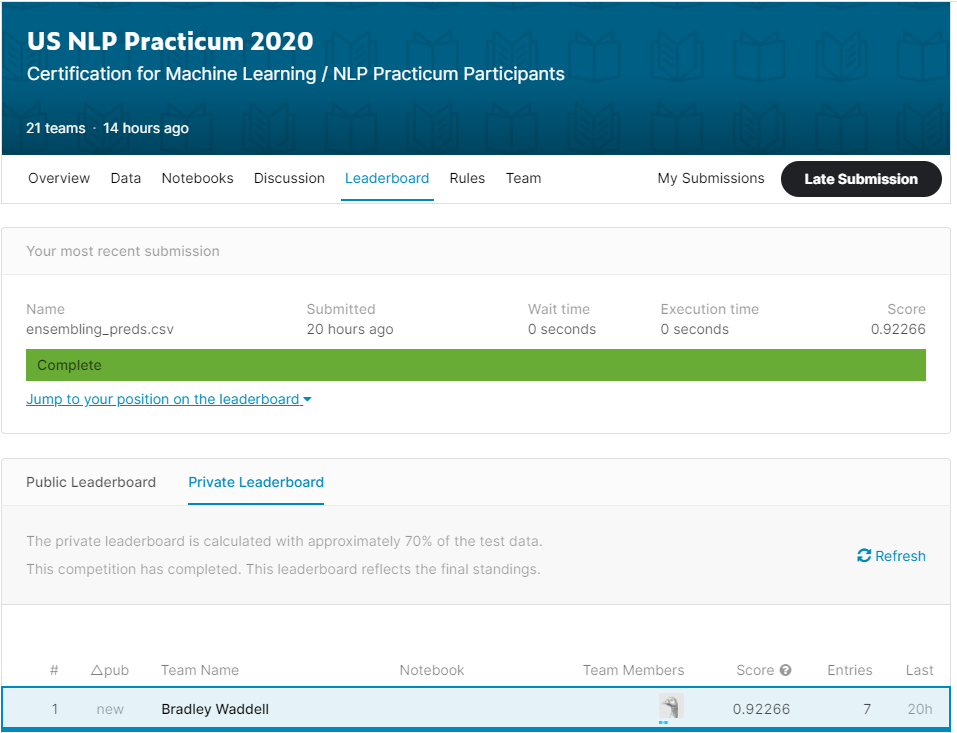

In [12]:
from IPython.display import Image 
pil_img = Image(filename="NLP_practicum_submission.png")
display(pil_img)